# Telecom Churn Prediction - Starter Notebook

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno
#pip install imblearn

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#pd.set_option('display.max_rows', None)

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [3]:
#data_dict

In [4]:
df = data.copy()
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [5]:
percent_missing = (df.isnull().sum()/df.shape[0]) *100
percent_missing.sort_values(inplace=True,ascending=False)
#percent_missing

In [6]:
# Below code gives list of columns having more than 60% null
col_to_drop = percent_missing[percent_missing > 60].keys()

In [7]:
for col in col_to_drop:
    del df[col]

In [8]:
#Get least distinctive /less varaince feature
leastdisc= []
for col in df:
    if df[col].unique().size < 10:
        leastdisc.append(col)
leastdisc

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'churn_probability']

In [9]:
for col in leastdisc:
    print(df[col].value_counts())  

109    69999
Name: circle_id, dtype: int64
0.0    69297
Name: loc_og_t2o_mou, dtype: int64
0.0    69297
Name: std_og_t2o_mou, dtype: int64
0.0    69297
Name: loc_ic_t2o_mou, dtype: int64
6/30/2014    69999
Name: last_date_of_month_6, dtype: int64
7/31/2014    69600
Name: last_date_of_month_7, dtype: int64
8/31/2014    69266
Name: last_date_of_month_8, dtype: int64
0.0    67231
Name: std_og_t2c_mou_6, dtype: int64
0.0    67312
Name: std_og_t2c_mou_7, dtype: int64
0.0    66296
Name: std_og_t2c_mou_8, dtype: int64
0.0    67231
Name: std_ic_t2o_mou_6, dtype: int64
0.0    67312
Name: std_ic_t2o_mou_7, dtype: int64
0.0    66296
Name: std_ic_t2o_mou_8, dtype: int64
0    64896
1     4688
2      389
3       20
4        6
Name: monthly_2g_6, dtype: int64
0    64695
1     4806
2      467
3       27
4        3
5        1
Name: monthly_2g_7, dtype: int64
0    64817
1     4738
2      413
3       24
4        6
5        1
Name: monthly_2g_8, dtype: int64
0    62867
1     7132
Name: churn_probability, 

In [10]:
# drop least distinctive columns 
col_to_drop= ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
              'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6',
              'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

for col in col_to_drop:
    del df[col]

In [11]:
percent_missing = (df.isnull().sum()/df.shape[0]) *100
percent_missing.sort_values(inplace=True,ascending=False)
percent_missing

std_og_t2f_mou_8      5.290076
loc_og_mou_8          5.290076
loc_og_t2c_mou_8      5.290076
loc_ic_t2m_mou_8      5.290076
og_others_8           5.290076
                        ...   
max_rech_amt_6        0.000000
max_rech_amt_7        0.000000
max_rech_amt_8        0.000000
last_day_rch_amt_6    0.000000
churn_probability     0.000000
Length: 129, dtype: float64

In [12]:
df.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,1,0,0,0,0,710,0.0,0.0,0.0,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0,0,0,0,882,0.0,0.0,0.0,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0,0,0,0,982,0.0,0.0,0.0,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,0,0,1,0,647,0.0,0.0,0.0,0


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

Let's look at each variable's datatype:

In [13]:
df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 129 columns):
 #    Column               Dtype  
---   ------               -----  
 0    id                   int64  
 1    arpu_6               float64
 2    arpu_7               float64
 3    arpu_8               float64
 4    onnet_mou_6          float64
 5    onnet_mou_7          float64
 6    onnet_mou_8          float64
 7    offnet_mou_6         float64
 8    offnet_mou_7         float64
 9    offnet_mou_8         float64
 10   roam_ic_mou_6        float64
 11   roam_ic_mou_7        float64
 12   roam_ic_mou_8        float64
 13   roam_og_mou_6        float64
 14   roam_og_mou_7        float64
 15   roam_og_mou_8        float64
 16   loc_og_t2t_mou_6     float64
 17   loc_og_t2t_mou_7     float64
 18   loc_og_t2t_mou_8     float64
 19   loc_og_t2m_mou_6     float64
 20   loc_og_t2m_mou_7     float64
 21   loc_og_t2m_mou_8     float64
 22   loc_og_t2f_mou_6     float64
 23   loc_og_t2

Let's also summarize the features using the df.describe method:

In [14]:
df.describe(include="all")

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34999.000000,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,...,0.077730,0.081958,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,...,0.383189,0.381821,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000


In [15]:
df = df.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'id'], axis=1) 

In [16]:
## Imputations :: TODO

In [17]:
missing_data_percent = df.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [18]:
imp = SimpleImputer(strategy='constant', fill_value=0)
df[impute_cols] = imp.fit_transform(df[impute_cols])

In [19]:
df.isnull().sum()

arpu_6               0
arpu_7               0
arpu_8               0
onnet_mou_6          0
onnet_mou_7          0
                    ..
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
churn_probability    0
Length: 125, dtype: int64

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [20]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X.shape, y.shape

((69999, 124), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , stratify=y, random_state =42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 124), (14000, 124), (55999,), (14000,))

In [22]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
38032,92.610,320.271,391.980,97.56,445.04,519.78,15.68,63.61,155.69,1.55,...,0,0,0,0,0,0,846,0.00,0.0,0.0
69689,298.625,45.560,0.000,90.74,35.68,0.00,272.79,22.88,0.00,0.00,...,1,0,0,0,0,0,462,0.00,0.0,0.0
8224,196.111,203.800,486.918,209.59,346.81,816.51,108.43,225.09,77.71,9.64,...,1,0,0,0,0,0,1006,0.00,0.0,0.0
40850,139.321,157.021,159.608,91.54,72.31,82.14,7.41,34.83,31.93,0.00,...,0,0,0,0,0,0,502,0.00,0.0,0.0
69476,210.940,183.400,198.260,7.94,14.93,8.76,194.64,145.86,145.98,0.00,...,0,0,0,0,0,0,2305,5.35,0.0,0.0


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

In [23]:
#msno.bar(X_train)

In [24]:
#msno.matrix(X_train)

Lets also calculate the % missing data for each column:

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [25]:
''''missing_data_percent = X_train.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols'''

"'missing_data_percent = X_train.isnull().any()\nimpute_cols = missing_data_percent[missing_data_percent.gt(0)].index\nimpute_cols"

In [26]:
'''imp = SimpleImputer(strategy='constant', fill_value=0)
X_train[impute_cols] = imp.fit_transform(X_train[impute_cols])'''

"imp = SimpleImputer(strategy='constant', fill_value=0)\nX_train[impute_cols] = imp.fit_transform(X_train[impute_cols])"

In [27]:
#msno.bar(X_train)

In [28]:
X_train.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,...,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,283.289565,277.942606,277.812549,127.392096,127.985636,125.186763,191.421571,189.369167,186.128604,9.424553,...,0.076626,0.078555,0.082073,0.072805,0.078662,0.085644,1220.828711,67.948789,65.501282,59.718041
std,342.411676,352.642365,351.334025,294.088933,304.504564,305.501177,316.196645,317.798191,319.925221,56.503464,...,0.363379,0.389957,0.385568,0.543579,0.595327,0.681911,953.436926,271.715732,264.802536,255.285624
min,-2041.228000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000
25%,93.318000,86.336500,83.596000,5.390000,4.910000,4.080000,28.580000,26.790000,23.610000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.000000
50%,197.007000,191.421000,191.374000,30.930000,29.140000,27.630000,89.660000,85.790000,82.710000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,869.000000,0.000000,0.000000,0.000000
75%,369.921000,364.384500,368.924000,113.435000,108.625000,105.085000,222.885000,218.130000,215.745000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1811.000000,0.000000,0.000000,0.000000
max,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,2850.980000,...,9.000000,16.000000,16.000000,29.000000,24.000000,41.000000,4337.000000,12916.220000,9165.600000,11166.210000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:>

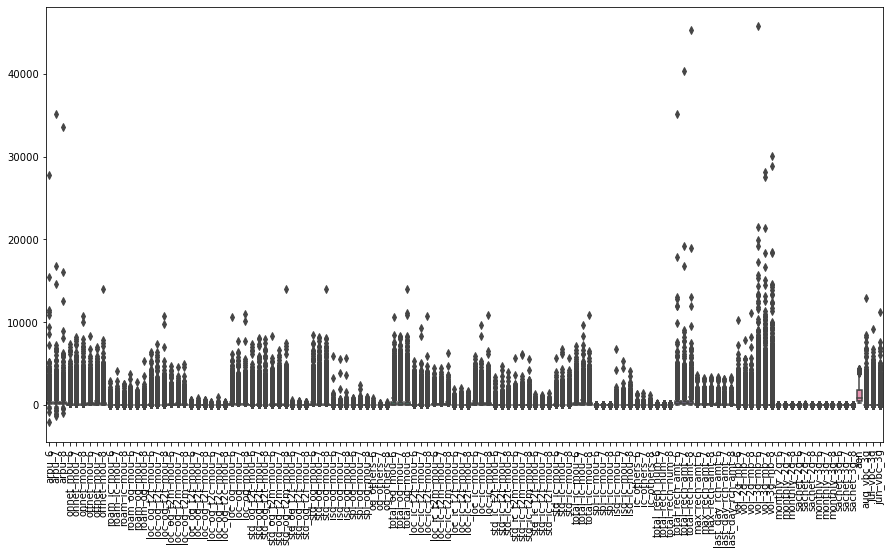

In [29]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = X_train)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [30]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<AxesSubplot:>

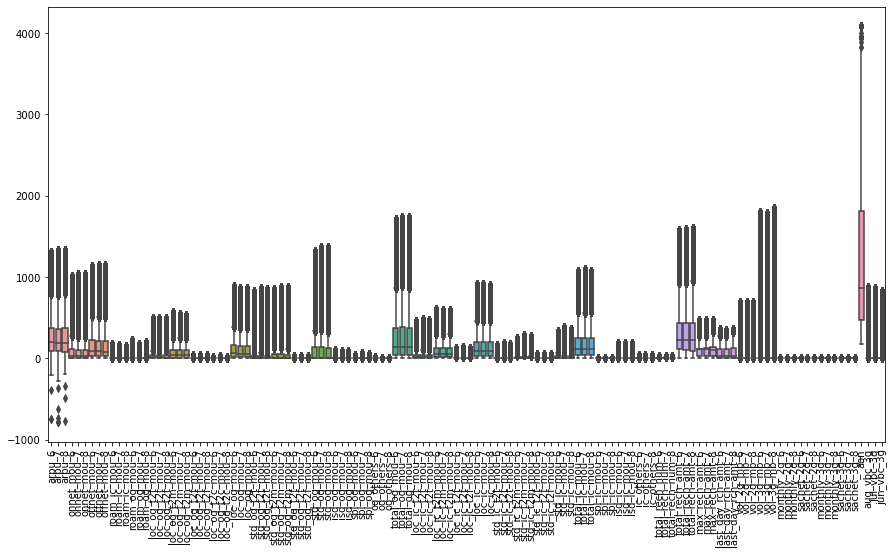

In [31]:
X_train_filtered = X_train.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = X_train_filtered)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [32]:
#X_train_filtered = X_train
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_filtered)

<AxesSubplot:>

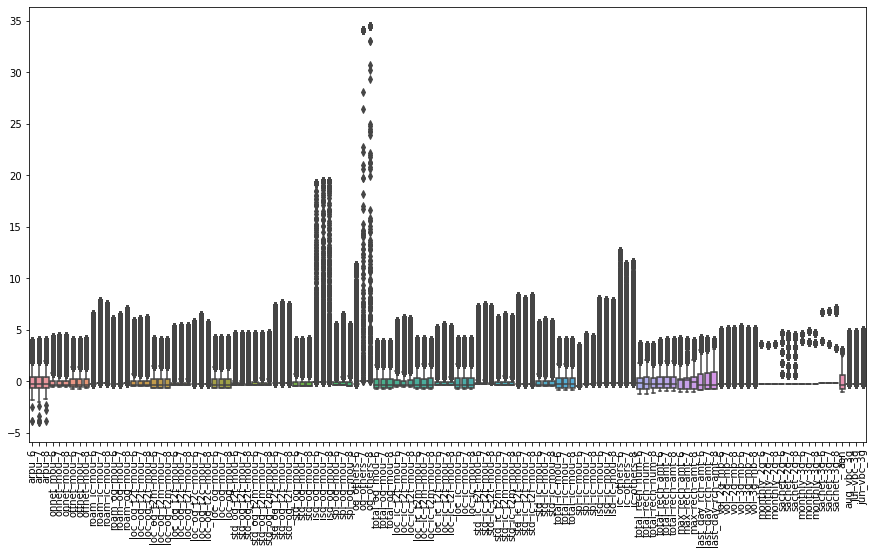

In [33]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns=X_train.columns))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<AxesSubplot:>

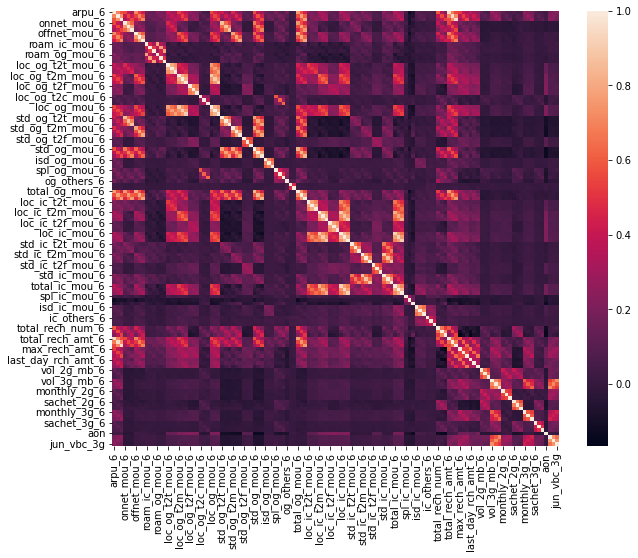

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_scaled, columns=X_train.columns).corr())

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

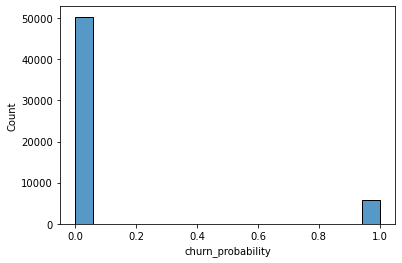

In [35]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [36]:
#rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
#rf.fit(X_train_scaled, y_train)

In [37]:
#feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})
#feature_importances.nlargest(10, 'importance')

In [38]:
#plt.figure(figsize=(15,8))
#plt.xticks(rotation=90)
#plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<AxesSubplot:>

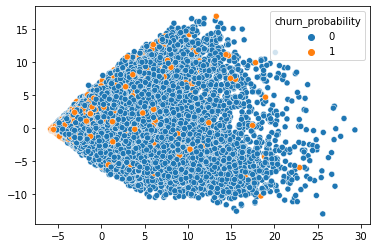

In [71]:
pca = PCA(random_state=42)
pca_components = pca.fit_transform(X_train_scaled)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<AxesSubplot:>

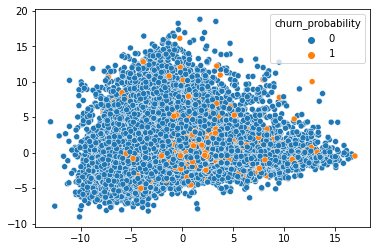

In [40]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [72]:
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.16074551 0.24786055 0.30335821 0.35036383 0.38765125 0.41735953
 0.44580591 0.47172617 0.49651392 0.52036545 0.5416943  0.56281457
 0.5816453  0.5991743  0.61603124 0.63118954 0.6447284  0.65753483
 0.66982919 0.68177996 0.69360482 0.70496075 0.71609188 0.72647858
 0.73606212 0.74532076 0.75432282 0.76298449 0.77081563 0.7784258
 0.78589664 0.79295692 0.79988106 0.80671139 0.8133132  0.81959923
 0.82560991 0.83161637 0.83743653 0.84310017 0.84844446 0.85367125
 0.85883937 0.86386689 0.86857362 0.87312353 0.87759405 0.88201127
 0.88632137 0.89060057 0.89477123 0.89882423 0.90265624 0.9064548
 0.91021166 0.91368564 0.91709538 0.92038718 0.92366851 0.92687881
 0.9297784  0.93254749 0.93527204 0.93796901 0.94062912 0.94325525
 0.94582672 0.94830061 0.95072327 0.95309584 0.95541339 0.95762656
 0.95982838 0.96198136 0.96406149 0.96610186 0.96812695 0.97003676
 0.9719146  0.97373959 0.975527   0.97728057 0.97895646 0.98056059
 0.98215584 0.98364573 0.9850905  0.98639817 0.98759673 0.988762

Text(0, 0.5, 'Cumulative Variance')

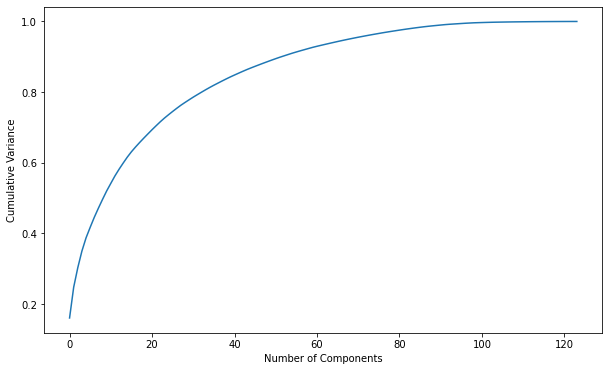

In [73]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [74]:
# Importing incremental PCA
from sklearn.decomposition import IncrementalPCA

In [75]:
# Instantiate PCA with 60 components
pca_final = IncrementalPCA(n_components=60)

In [76]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)

In [77]:
#smote = SMOTE(random_state = 42)
X_train_resamp, y_train_resamp = smote.fit_resample(X_train_pca, y_train)
X_train_resamp.shape

(100586, 60)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [78]:
rf = RandomForestClassifier(random_state=42,n_estimators=10, n_jobs=-1, max_depth=5, oob_score = True)
rf.fit(X_train_resamp, y_train_resamp)

RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=42)

In [43]:
params = {
    'max_depth': [5, 10, 20],
    #'min_samples_leaf': [20, 50, 100],
   # 'max_features': [5, 10, 15, 20],
    'n_estimators': [10, 50, 100, 200]
}

In [44]:
grid_search = GridSearchCV(estimator= rf, param_grid = params,
                          cv=4, n_jobs=-1, verbose=1, scoring = 'accuracy' )

In [45]:
#grid_search.fit(pca_components , y_train_resamp)

In [46]:
#rf_best = grid_search.best_estimator_

In [47]:
rf.oob_score_

0.9066411900212504

In [48]:
#plot_roc_curve()


In [79]:
def evaluate_model(rf_classifier):
    y_train_pred = rf_classifier.predict(X_train_resamp) 
    print("Train set Performance")
    print(accuracy_score(y_train_resamp, y_train_pred))
    print(confusion_matrix(y_train_resamp, y_train_pred)) 
    

In [80]:
evaluate_model(rf)

Train set Performance
0.8100232636748653
[[40359  9934]
 [ 9175 41118]]


In [51]:
'''feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(124)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])'''

"feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(124)], \n                                    'importance':rf.feature_importances_})\n\nplt.figure(figsize=(15,8))\nplt.xticks(rotation=90)\nplt.bar(feature_importances['col'], feature_importances['importance'])"

In [52]:
X_test_scaled = scale.transform(X_test)

In [53]:
pca_test_components = pca.transform(X_test_scaled)

In [55]:
X_test_resamp, y_test_resamp = smote.fit_resample(pca_test_components, y_test)

In [56]:
def evaluate_test_data(rf_classifier):
    y_test_pred = rf_classifier.predict(X_test_resamp) 
    print("Test set Performance")
    print(accuracy_score(y_test_resamp, y_test_pred))
    print(confusion_matrix(y_test_resamp, y_test_pred)) 

In [57]:
evaluate_test_data(rf)

Test set Performance
0.9057142857142857
[[12518    56]
 [ 1264   162]]


In [58]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
smote = SMOTE(random_state = 42)
rf = RandomForestClassifier(random_state=42,n_estimators=10, n_jobs=-1, max_depth=5, oob_score = True)

In [59]:
pipeline = imbpipeline(steps = [('imputation',imp),
                             ('scaling',scale),
                             ('pca',pca),
                             ('smt', smote),
                             ('model',rf)])

In [60]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=-1,
                                        oob_score=True, random_state=42))])

In [61]:
train_score = pipeline.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9087840854300969


In [62]:
test_score = pipeline.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9055714285714286


# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

In [ ]:
lr.score(pca_components[:,:2], y_train)

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
#pipe = Pipeline(steps = [('imputation',imp),
  #                       ('scaling',scale),
 #                        ('pca',pca),
 #                        ('model',lr)])

In [ ]:
#pipe.fit(X_train, y_train)

In [ ]:
#train_score = pipe.score(X_train, y_train)
#print("Training accuracy:", train_score)

In [ ]:
#test_score = pipe.score(X_test, y_test)
#print("Test accuracy:", test_score)

Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [63]:
confusion_matrix(y_train, pipeline.predict(X_train))

array([[50113,   180],
       [ 4928,   778]], dtype=int64)

In [64]:
confusion_matrix(y_test, pipeline.predict(X_test))

array([[12517,    57],
       [ 1265,   161]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [65]:
precision_score(y_test, pipeline.predict(X_test))

0.7385321100917431

In [66]:
recall_score(y_test, pipeline.predict(X_test))

0.11290322580645161

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [67]:
new_vars = X_train.columns
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 124)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [68]:
unseen['churn_probability'] = pipeline.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [69]:
output.to_csv('submission_1506.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.